## Train log
lr = 0.0005, n_epochs = 500
- Vanilla SGD: Train Loss: 0.379675, Train Accuracy: 88.75 %, Val Loss: 0.405204, Val Accuracy: 87.20 %
- SGD With momentum: Train Loss: 0.212021, Train Accuracy: 93.15 %, Val Loss: 0.326893, Val Accuracy: 89.25 %
- AdaGrad: Train Loss: 4.367951, Train Accuracy: 3.53 %, Val Loss: 4.308281, Val Accuracy: 3.45 %
- RMSProp: Train Loss: 0.269417, Train Accuracy: 92.07 %, Val Loss: 0.308829, Val Accuracy: 90.20 %
- AdaDelta: Train Loss: 0.697394, Train Accuracy: 80.63 %, Val Loss: 0.723505, Val Accuracy: 80.20 %

In [1]:
import numpy as np              # For numerical operations and array manipulations
import pandas as pd            # For data manipulation and analysis
import matplotlib.pyplot as plt  # Basic plotting library
import seaborn as sns           # Statistical data visualization
import math
np.random.seed(42)
%matplotlib inline

In [2]:
from models import MLP
from utils import nll_loss, plot_loss, train_with_acc
from optim import *

## Data Analysis

In [3]:
DATA_PATH = "../data/letter+recognition/letter-recognition.data"

In [4]:
x, y_letters = [], []

with open(DATA_PATH, "r") as file:
    lines = file.read().splitlines()

    for line in lines:
        feat_list = line.split(',')
        x.append([int(feat) for feat in feat_list[1:]])
        y_letters.append(feat_list[0])

len(x), len(y_letters)

(20000, 20000)

In [5]:
x[0]

[2, 8, 3, 5, 1, 8, 13, 0, 6, 6, 10, 8, 0, 8, 0, 8]

In [6]:
set(y_letters)

{'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z'}

In [24]:
sorted_letters = sorted(list(set(y_letters)))
stoi = {letter: i for i, letter in enumerate(sorted_letters)}
itos = {i: letter for i, letter in enumerate(sorted_letters)}
stoi

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'J': 9,
 'K': 10,
 'L': 11,
 'M': 12,
 'N': 13,
 'O': 14,
 'P': 15,
 'Q': 16,
 'R': 17,
 'S': 18,
 'T': 19,
 'U': 20,
 'V': 21,
 'W': 22,
 'X': 23,
 'Y': 24,
 'Z': 25}

In [8]:
y = [stoi[letter] for letter in y_letters]
len(y)

20000

In [9]:
y[0]

19

In [11]:
x_array = np.array(x, dtype=np.float64)
y_array = np.array(y, dtype=np.int32)
x_array.shape, y_array.shape

((20000, 16), (20000,))

In [12]:
x_array[0]

array([ 2.,  8.,  3.,  5.,  1.,  8., 13.,  0.,  6.,  6., 10.,  8.,  0.,
        8.,  0.,  8.])

In [13]:
# Calculate statistics
stats = {
    'count': x_array.shape[0],
    'mean': np.mean(x_array, axis=0),
    'std': np.std(x_array, axis=0),
    'min': np.min(x_array, axis=0),
    '25%': np.percentile(x_array, 25, axis=0),
    '50%': np.median(x_array, axis=0),
    '75%': np.percentile(x_array, 75, axis=0),
    'max': np.max(x_array, axis=0)
}

# Display statistics in a format similar to pandas describe()
for stat_name, values in stats.items():
    if isinstance(values, np.ndarray):
        print(f"{stat_name:<6}", end="")
        for val in values:
            print(f"{val:>12.6f}", end="")
        print()
    else:
        print(f"{stat_name:<6}{values:>12}")

count        20000
mean      4.023550    7.035500    5.121850    5.372450    3.505850    6.897600    7.500450    4.628600    5.178650    8.282050    6.454000    7.929000    3.046100    8.338850    3.691750    7.801200
std       1.913164    3.304473    2.014523    2.261334    2.190403    2.025985    2.325296    2.699900    2.380763    2.488413    2.631004    2.080567    2.332483    1.546684    2.567008    1.617430
min       0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000
25%       3.000000    5.000000    4.000000    4.000000    2.000000    6.000000    6.000000    3.000000    4.000000    7.000000    5.000000    7.000000    1.000000    8.000000    2.000000    7.000000
50%       4.000000    7.000000    5.000000    6.000000    3.000000    7.000000    7.000000    4.000000    5.000000    8.000000    6.000000    8.000000    3.000000    8.000000    3.00000

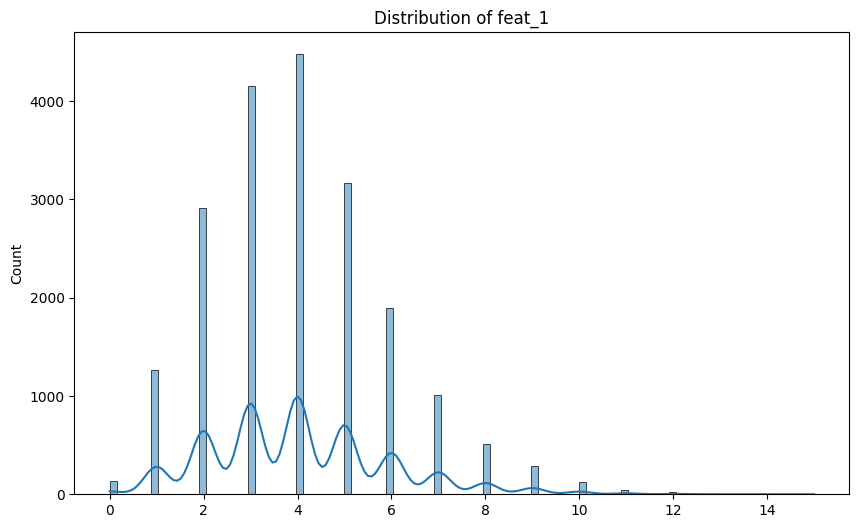

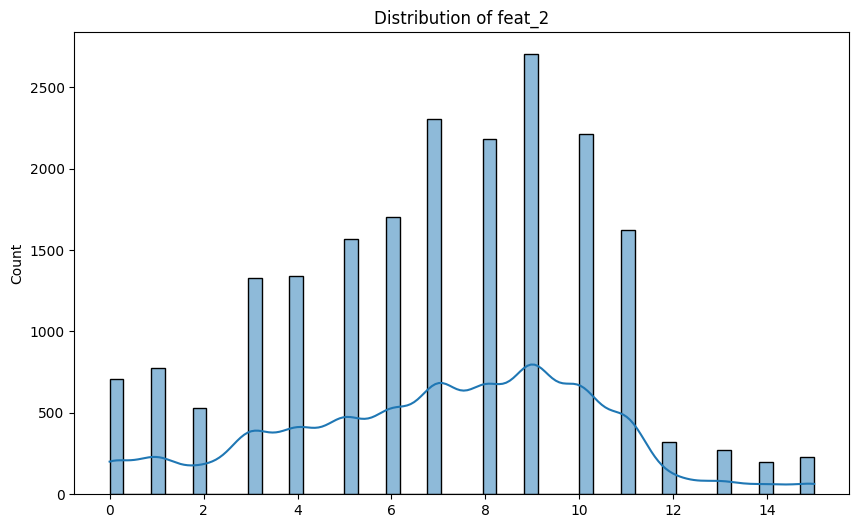

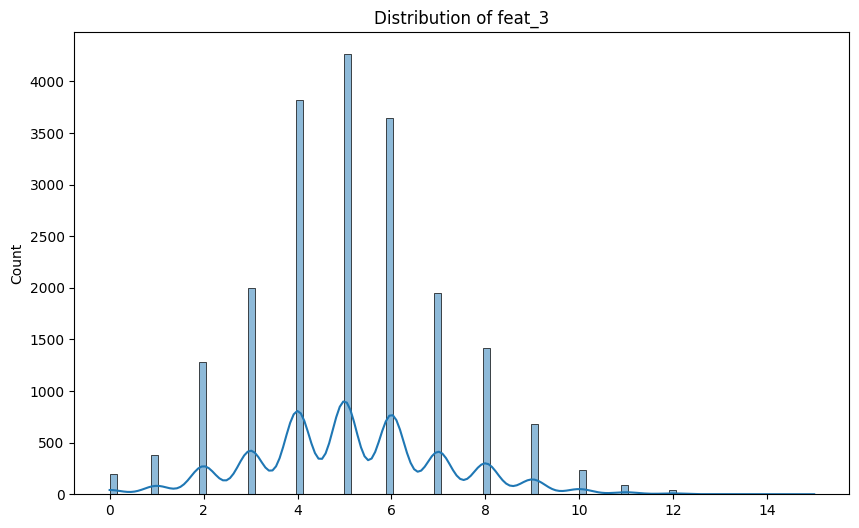

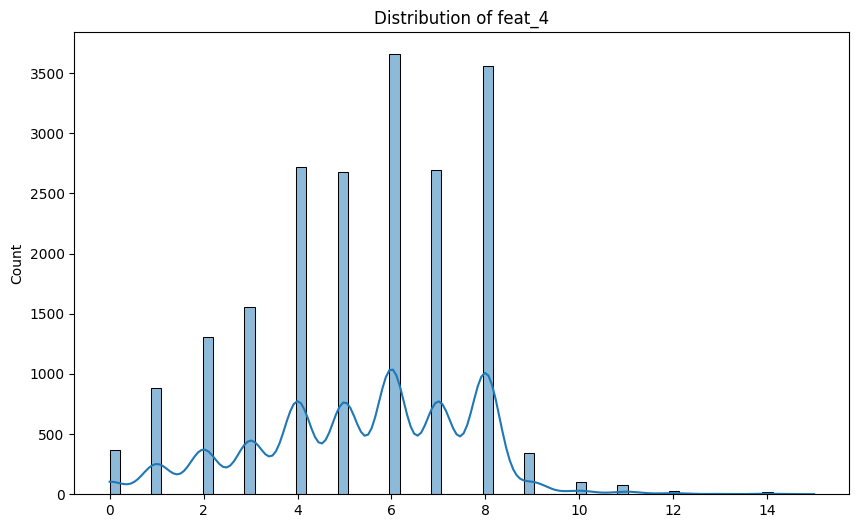

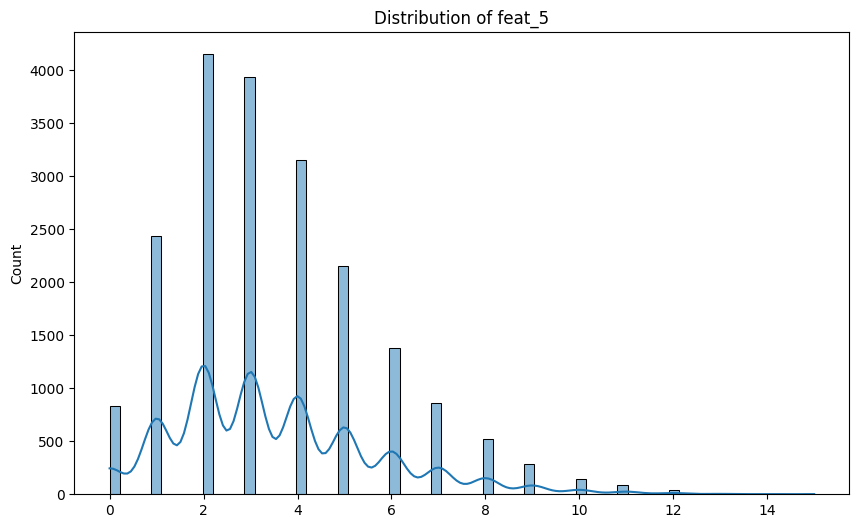

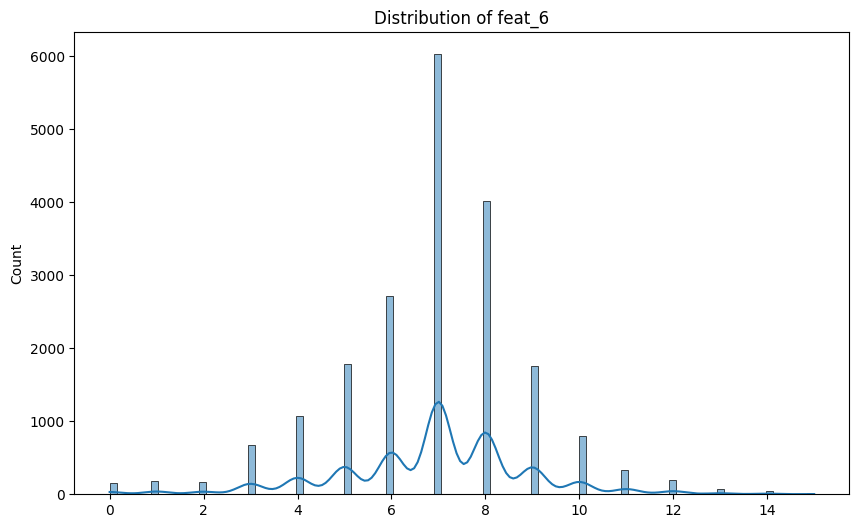

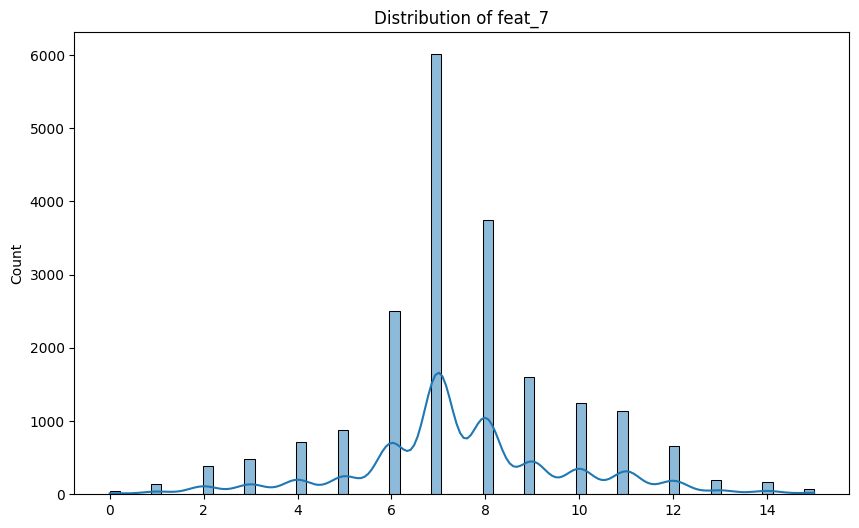

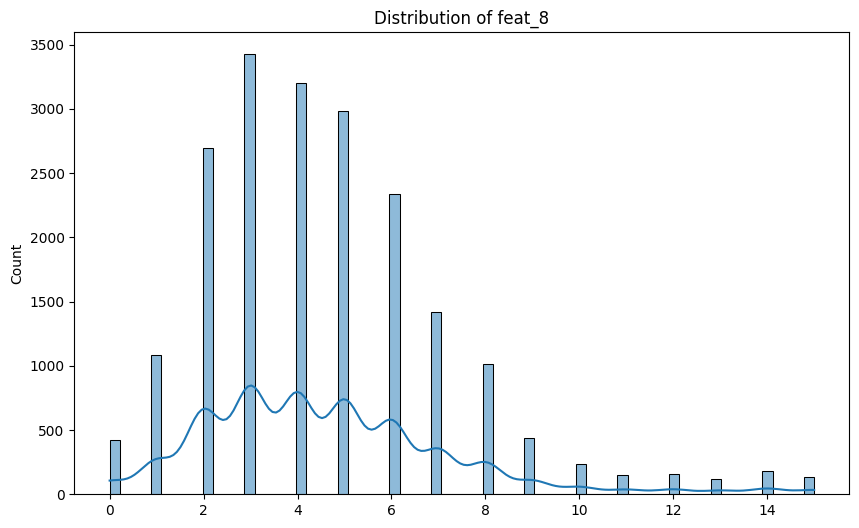

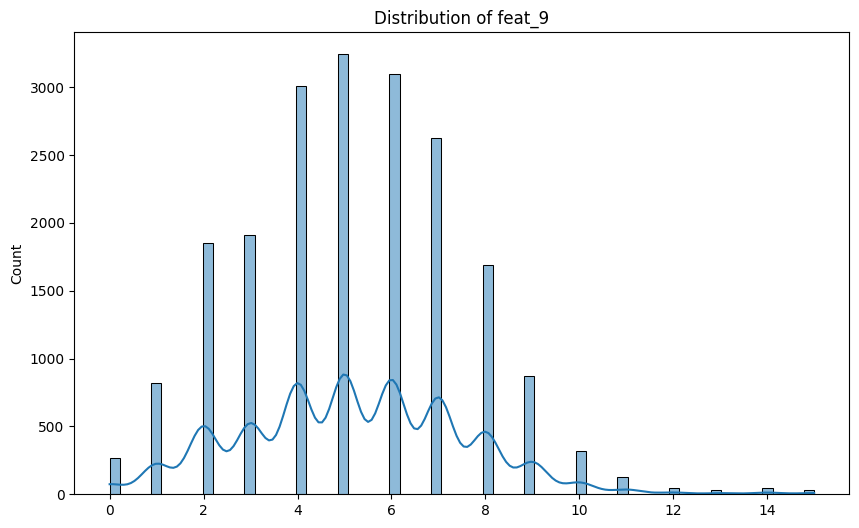

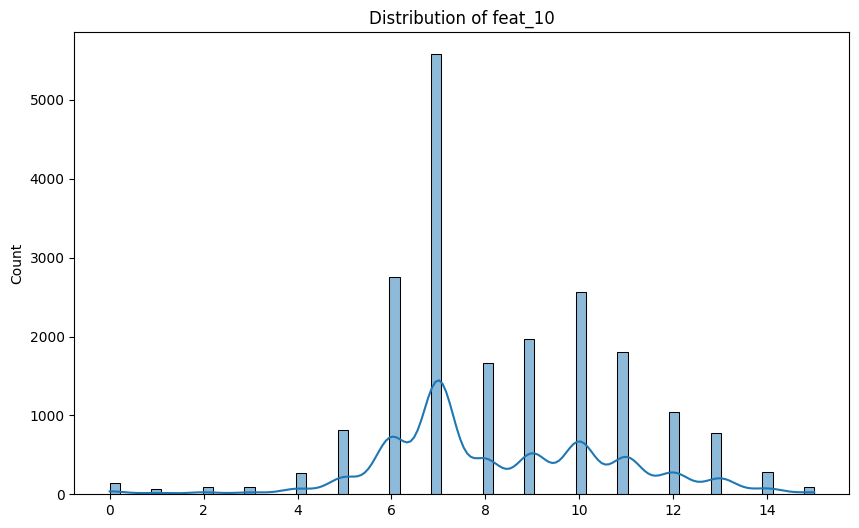

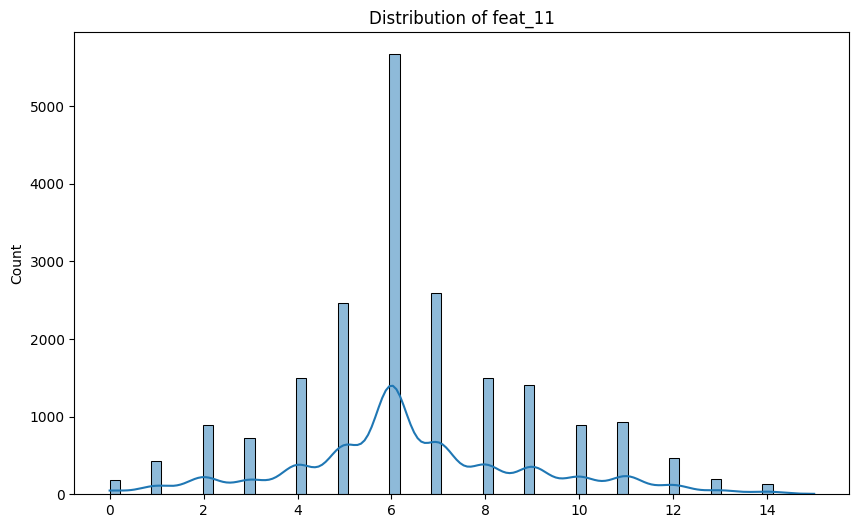

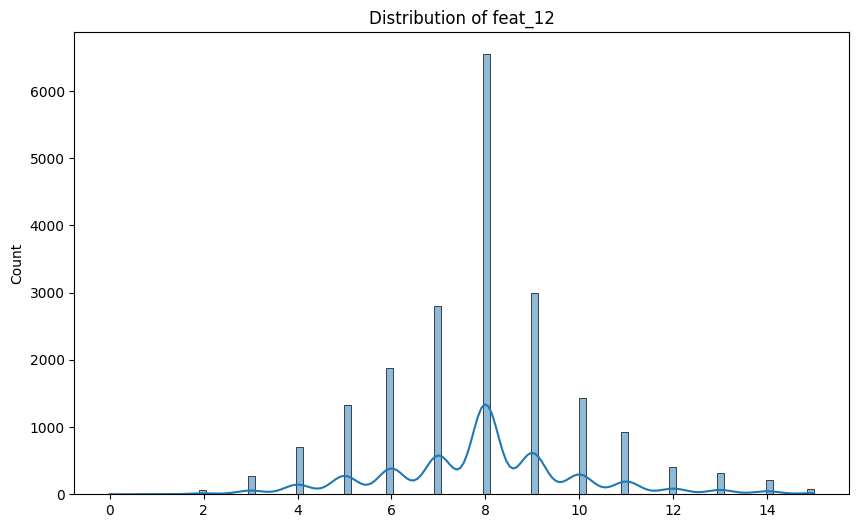

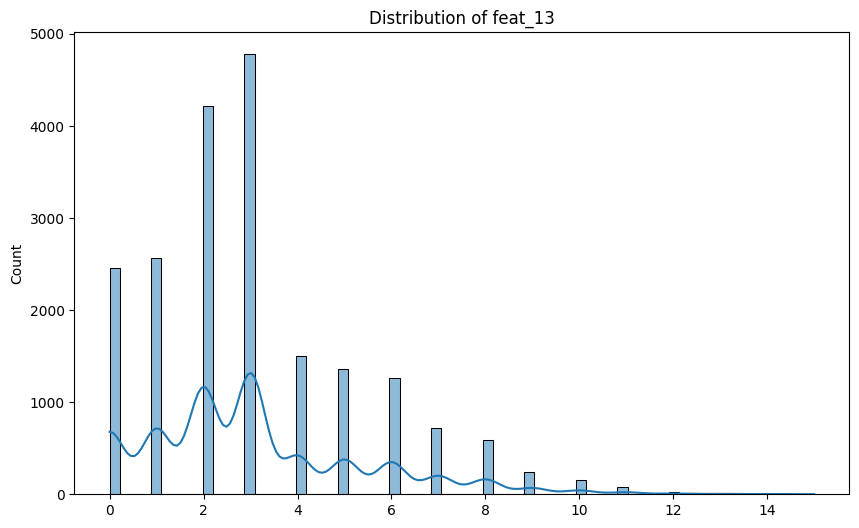

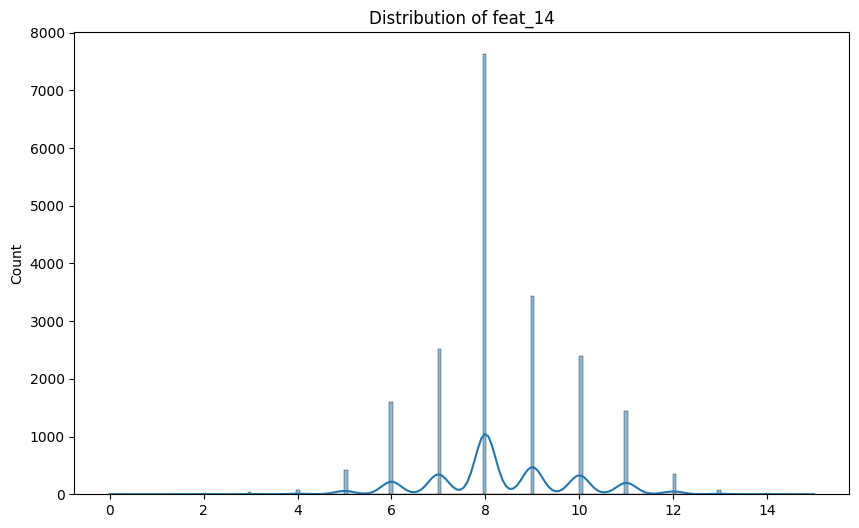

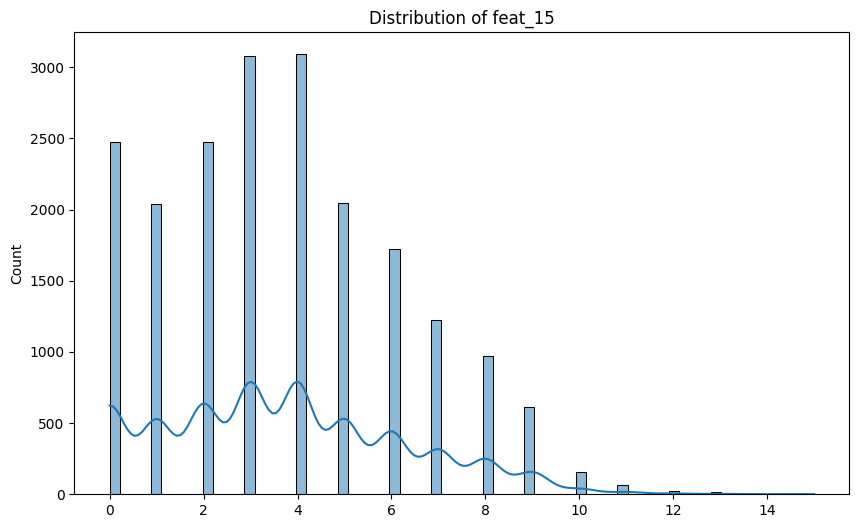

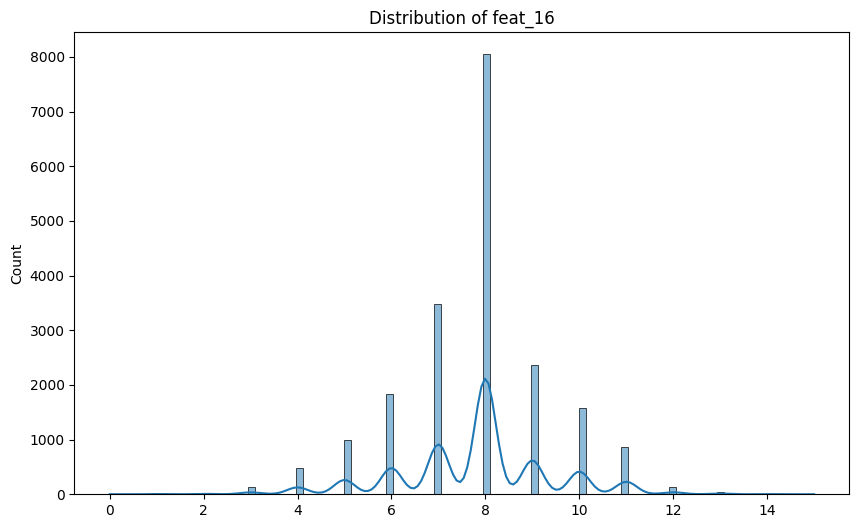

In [14]:
# Histograms for numeric features

for i in range(16):
    plt.figure(figsize=(10, 6))
    sns.histplot(x_array[:, i], kde=True)
    plt.title(f'Distribution of feat_{i + 1}')
    plt.show()

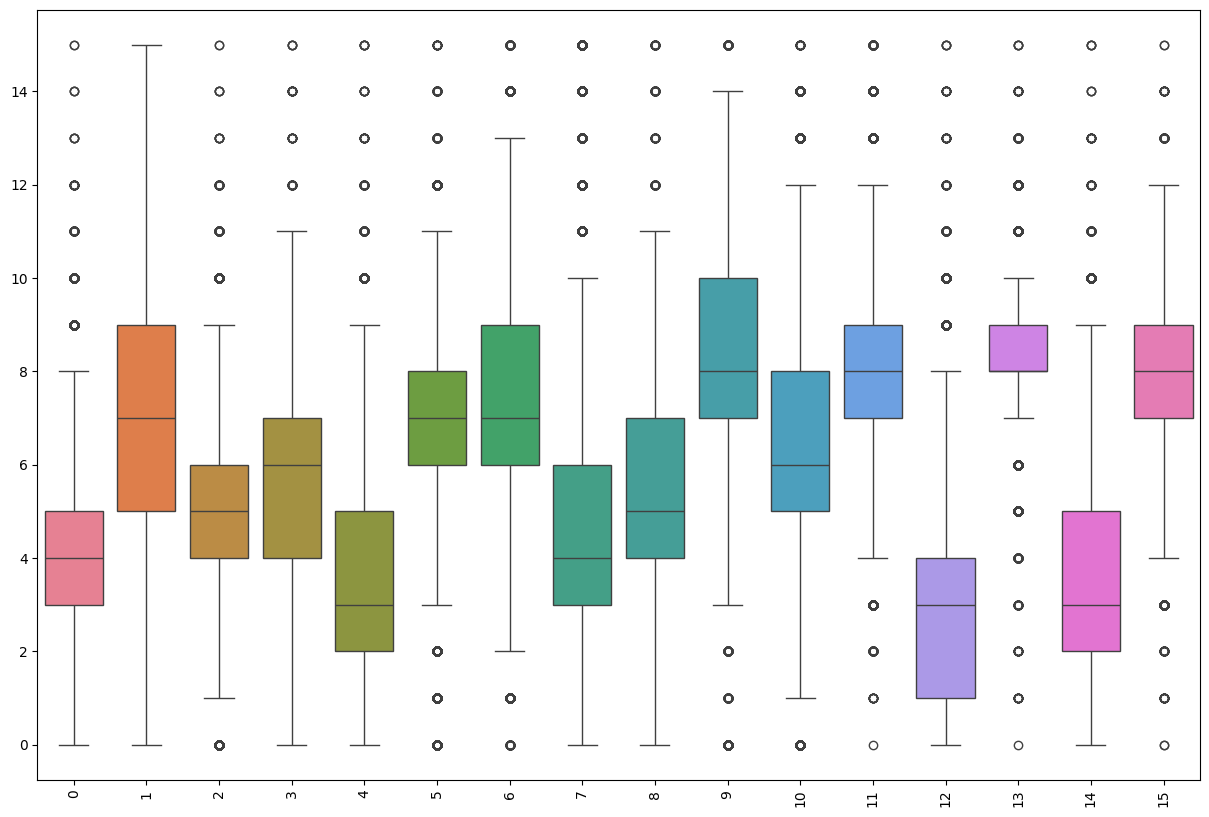

In [15]:
# Box plots for outlier detection
plt.figure(figsize=(15, 10))
sns.boxplot(data=x_array)
plt.xticks(rotation=90)
plt.show()

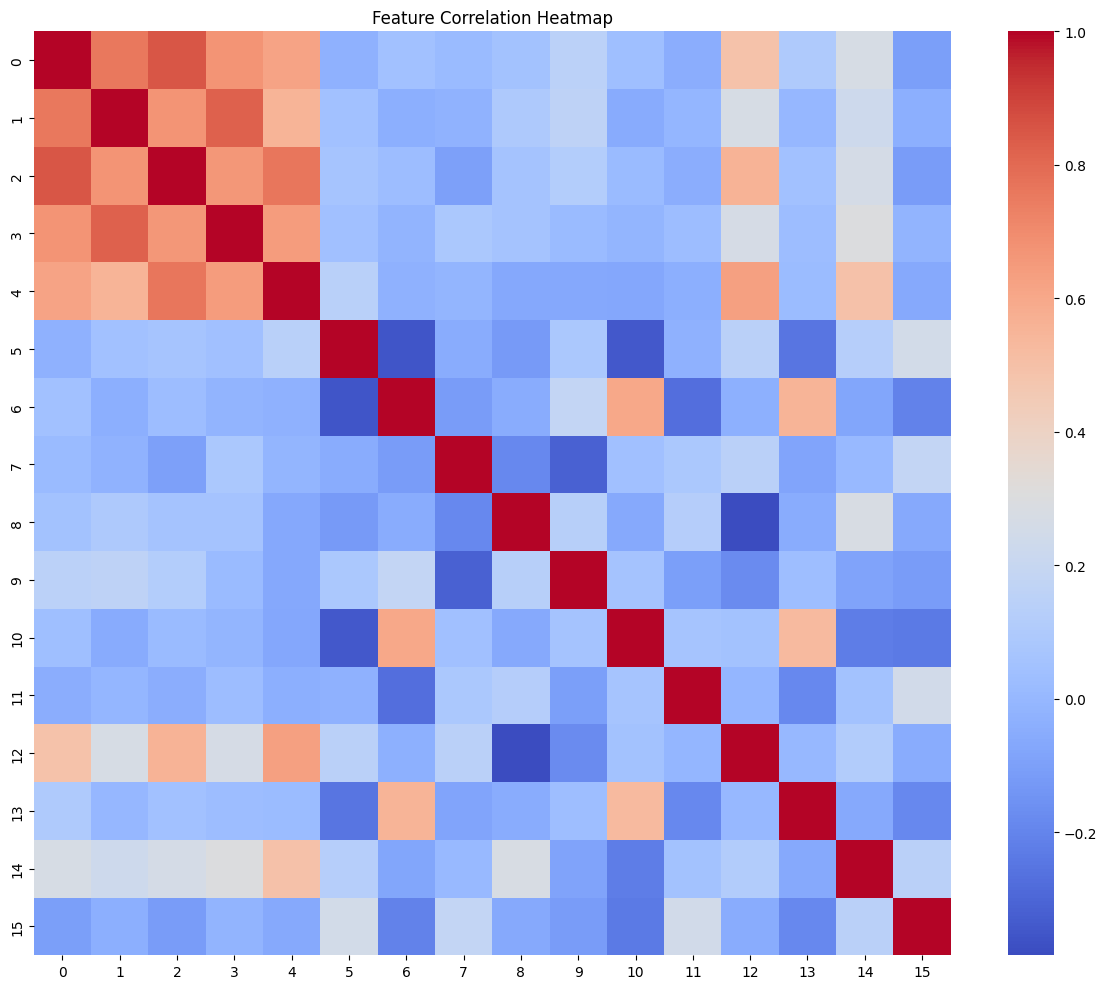

In [17]:
# 1. Analyze feature correlations
plt.figure(figsize=(12, 10))
corr = pd.DataFrame(x_array).corr()
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

## Data Preprocessing

In [18]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [20]:
# First split: 80% train, 20% temp (which will be further split)
X_train, X_temp, y_train, y_temp = train_test_split(
    x_array, y_array, test_size=0.2, random_state=42
)

# Second split: Split the temp set into validation and test (50% each of the 20%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# Verify the split proportions
print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(x_array):.1%})")
print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(x_array):.1%})")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(x_array):.1%})")

Training set: 16000 samples (80.0%)
Validation set: 2000 samples (10.0%)
Test set: 2000 samples (10.0%)


In [ ]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [22]:
X_train_scaled.shape

(16000, 16)

In [25]:
unique_values, counts = np.unique(y_train, return_counts=True)
for value, count in zip(unique_values, counts):
    print(f"Value {itos[value]} appears {count} times")

Value A appears 640 times
Value B appears 613 times
Value C appears 599 times
Value D appears 649 times
Value E appears 627 times
Value F appears 635 times
Value G appears 613 times
Value H appears 590 times
Value I appears 609 times
Value J appears 598 times
Value K appears 609 times
Value L appears 606 times
Value M appears 624 times
Value N appears 632 times
Value O appears 608 times
Value P appears 630 times
Value Q appears 617 times
Value R appears 598 times
Value S appears 577 times
Value T appears 633 times
Value U appears 630 times
Value V appears 606 times
Value W appears 604 times
Value X appears 633 times
Value Y appears 618 times
Value Z appears 602 times


In [27]:
X_train_scaled[0]

array([0.26666667, 0.46666667, 0.33333333, 0.33333333, 0.26666667,
       0.4       , 0.46666667, 0.2       , 0.46666667, 0.73333333,
       0.53333333, 0.6       , 0.2       , 0.53333333, 0.26666667,
       0.53333333])

In [28]:
np.save('../data/letter+recognition/X_train.npy', X_train_scaled)
np.save('../data/letter+recognition/y_train.npy', y_train)
np.save('../data/letter+recognition/X_val.npy', X_val_scaled)
np.save('../data/letter+recognition/y_val.npy', y_val)
np.save('../data/letter+recognition/X_test.npy', X_test_scaled)
np.save('../data/letter+recognition/y_test.npy', y_test)

## Now create MLP

In [3]:
X_train = np.load('../data/letter+recognition/X_train.npy')
y_train = np.load('../data/letter+recognition/y_train.npy')
y_train = y_train.reshape((len(y_train), 1))
X_val = np.load('../data/letter+recognition/X_val.npy')
y_val = np.load('../data/letter+recognition/y_val.npy')
y_val = y_val.reshape((len(y_val), 1))
X_test = np.load('../data/letter+recognition/X_test.npy')
y_test = np.load('../data/letter+recognition/y_test.npy')
y_test = y_test.reshape((len(y_test), 1))

In [4]:
y_train.shape

(16000, 1)

In [5]:
num_feats = X_train.shape[-1]
num_feats

16

In [6]:
num_classes = 26

## All optimizers

### SGD

In [7]:
model = MLP(input_dim=num_feats, hidden_dim=3*num_feats, output_dim=num_classes) # for regression
model.get_params_count()

2090

In [8]:
sgd_optim = SGDOptimizer(lr=0.0005)

In [9]:
train_losses, train_acc, val_losses, val_acc = train_with_acc(model, X_train, y_train, X_val, y_val, optim=sgd_optim, loss_fn=nll_loss, n_epochs=500, batch_size=512)

Epoch 1/500, Train Loss: 4.530142, Train Accuracy: 6.31 %, Val Loss: 3.231551, Val Accuracy: 12.40 %
Epoch 50/500, Train Loss: 0.912622, Train Accuracy: 75.52 %, Val Loss: 0.928283, Val Accuracy: 75.05 %
Epoch 100/500, Train Loss: 0.746516, Train Accuracy: 79.30 %, Val Loss: 0.772980, Val Accuracy: 79.10 %
Epoch 150/500, Train Loss: 0.658405, Train Accuracy: 81.53 %, Val Loss: 0.681993, Val Accuracy: 81.50 %
Epoch 200/500, Train Loss: 0.593227, Train Accuracy: 83.24 %, Val Loss: 0.617590, Val Accuracy: 82.35 %
Epoch 250/500, Train Loss: 0.539568, Train Accuracy: 84.63 %, Val Loss: 0.563864, Val Accuracy: 83.75 %
Epoch 300/500, Train Loss: 0.494723, Train Accuracy: 85.76 %, Val Loss: 0.524321, Val Accuracy: 84.50 %
Epoch 350/500, Train Loss: 0.458153, Train Accuracy: 86.77 %, Val Loss: 0.485518, Val Accuracy: 85.30 %
Epoch 400/500, Train Loss: 0.427436, Train Accuracy: 87.61 %, Val Loss: 0.454863, Val Accuracy: 85.90 %
Epoch 450/500, Train Loss: 0.401097, Train Accuracy: 88.27 %, Val Lo

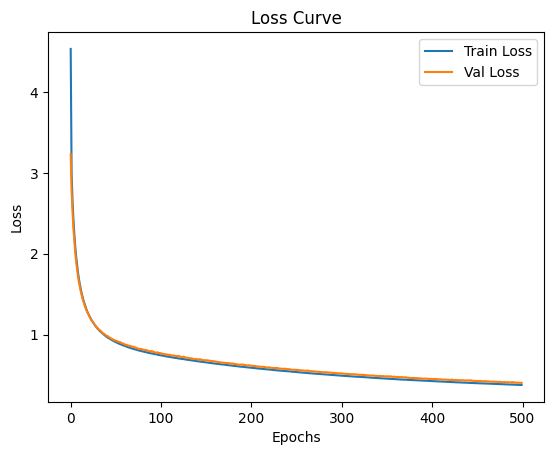

In [10]:
plot_loss(train_losses, val_losses)

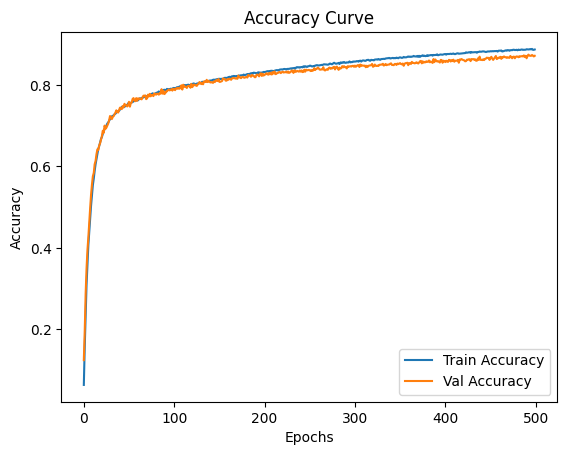

In [11]:
plt.plot(range(len(train_acc)), train_acc, label="Train Accuracy") 
plt.plot(range(len(val_acc)), val_acc, label="Val Accuracy") 

# plt.scatter(range(len(loss_values)), loss_values, c='red', s=20)

plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### SGD With Momentum

In [12]:
model = MLP(input_dim=num_feats, hidden_dim=3*num_feats, output_dim=num_classes)
model.get_params_count()

2090

In [13]:
sgd_momentum_optim = SGDWithMomentum(lr=0.0005, gamma=0.90)

In [14]:
train_losses, train_acc, val_losses, val_acc = train_with_acc(model, X_train, y_train, X_val, y_val, optim=sgd_momentum_optim, loss_fn=nll_loss, n_epochs=500, batch_size=512)

Epoch 1/500, Train Loss: 4.711770, Train Accuracy: 12.75 %, Val Loss: 2.596821, Val Accuracy: 21.70 %
Epoch 50/500, Train Loss: 0.492115, Train Accuracy: 85.20 %, Val Loss: 0.571897, Val Accuracy: 82.25 %
Epoch 100/500, Train Loss: 0.370784, Train Accuracy: 88.61 %, Val Loss: 0.425134, Val Accuracy: 85.65 %
Epoch 150/500, Train Loss: 0.311592, Train Accuracy: 90.13 %, Val Loss: 0.380693, Val Accuracy: 87.20 %
Epoch 200/500, Train Loss: 0.292450, Train Accuracy: 90.56 %, Val Loss: 0.345161, Val Accuracy: 88.50 %
Epoch 250/500, Train Loss: 0.262488, Train Accuracy: 91.72 %, Val Loss: 0.352338, Val Accuracy: 88.55 %
Epoch 300/500, Train Loss: 0.248733, Train Accuracy: 92.11 %, Val Loss: 0.313002, Val Accuracy: 89.85 %
Epoch 350/500, Train Loss: 0.236268, Train Accuracy: 92.60 %, Val Loss: 0.351746, Val Accuracy: 88.45 %
Epoch 400/500, Train Loss: 0.235453, Train Accuracy: 92.51 %, Val Loss: 0.325854, Val Accuracy: 89.70 %
Epoch 450/500, Train Loss: 0.216962, Train Accuracy: 93.10 %, Val L

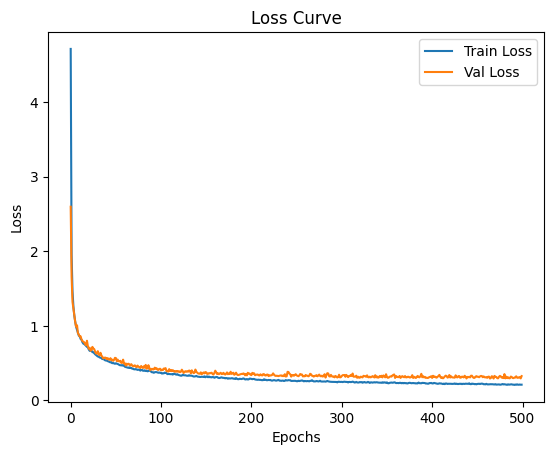

In [15]:
plot_loss(train_losses, val_losses)

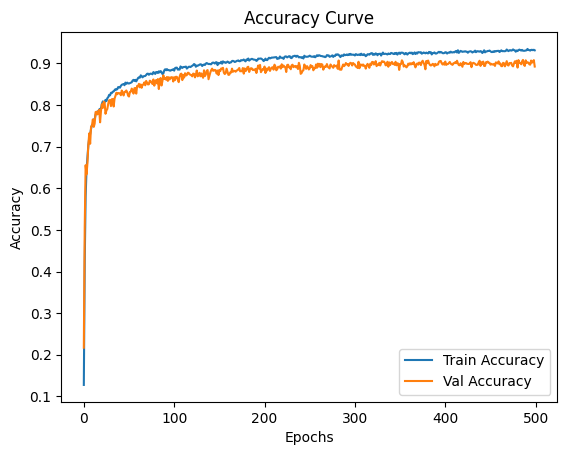

In [16]:
plt.plot(range(len(train_acc)), train_acc, label="Train Accuracy") 
plt.plot(range(len(val_acc)), val_acc, label="Val Accuracy") 

# plt.scatter(range(len(loss_values)), loss_values, c='red', s=20)

plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### AdaGrad

In [22]:
model = MLP(input_dim=num_feats, hidden_dim=3*num_feats, output_dim=num_classes)
model.get_params_count()

2090

In [23]:
adagrad = AdaGrad(lr=0.0005, epsilon=1e-8)

In [24]:
train_losses, train_acc, val_losses, val_acc = train_with_acc(model, X_train, y_train, X_val, y_val, optim=adagrad, loss_fn=nll_loss, n_epochs=500, batch_size=512)

Epoch 1/500, Train Loss: 12.164444, Train Accuracy: 3.93 %, Val Loss: 11.798184, Val Accuracy: 3.55 %
Epoch 50/500, Train Loss: 8.007602, Train Accuracy: 2.04 %, Val Loss: 7.907765, Val Accuracy: 1.90 %
Epoch 100/500, Train Loss: 6.849010, Train Accuracy: 2.16 %, Val Loss: 6.761626, Val Accuracy: 1.60 %
Epoch 150/500, Train Loss: 6.148608, Train Accuracy: 2.39 %, Val Loss: 6.068240, Val Accuracy: 1.65 %
Epoch 200/500, Train Loss: 5.667064, Train Accuracy: 2.51 %, Val Loss: 5.591837, Val Accuracy: 2.15 %
Epoch 250/500, Train Loss: 5.313890, Train Accuracy: 2.59 %, Val Loss: 5.242373, Val Accuracy: 2.60 %
Epoch 300/500, Train Loss: 5.041015, Train Accuracy: 2.78 %, Val Loss: 4.972308, Val Accuracy: 2.80 %
Epoch 350/500, Train Loss: 4.822163, Train Accuracy: 2.94 %, Val Loss: 4.755823, Val Accuracy: 2.90 %
Epoch 400/500, Train Loss: 4.642511, Train Accuracy: 3.13 %, Val Loss: 4.578390, Val Accuracy: 3.15 %
Epoch 450/500, Train Loss: 4.493112, Train Accuracy: 3.32 %, Val Loss: 4.431199, Va

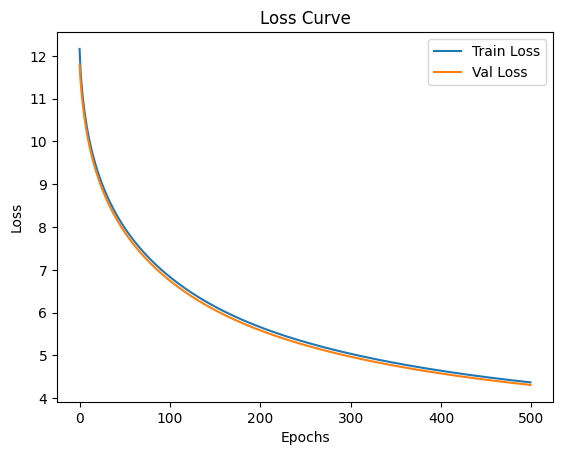

In [25]:
plot_loss(train_losses, val_losses)

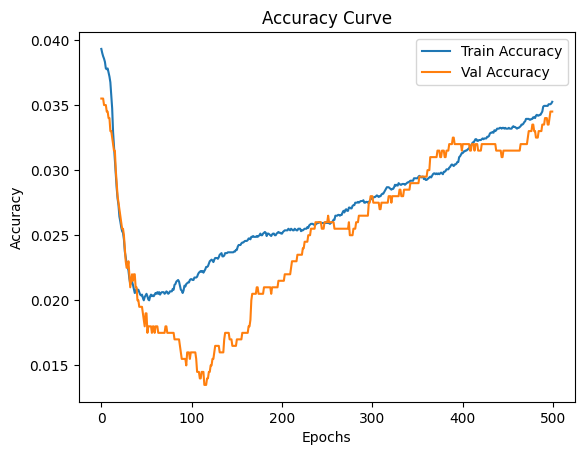

In [26]:
plt.plot(range(len(train_acc)), train_acc, label="Train Accuracy") 
plt.plot(range(len(val_acc)), val_acc, label="Val Accuracy") 

# plt.scatter(range(len(loss_values)), loss_values, c='red', s=20)

plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### RMSProp

In [27]:
model = MLP(input_dim=num_feats, hidden_dim=3*num_feats, output_dim=num_classes)
model.get_params_count()

2090

In [28]:
rmsprop = RMSProp(lr=0.002, epsilon=1e-8, beta=0.90)

In [29]:
train_losses, train_acc, val_losses, val_acc = train_with_acc(model, X_train, y_train, X_val, y_val, optim=rmsprop, loss_fn=nll_loss, n_epochs=500, batch_size=512)

Epoch 1/500, Train Loss: 7.908410, Train Accuracy: 2.39 %, Val Loss: 5.545073, Val Accuracy: 2.30 %
Epoch 50/500, Train Loss: 0.807602, Train Accuracy: 77.63 %, Val Loss: 0.821892, Val Accuracy: 77.25 %
Epoch 100/500, Train Loss: 0.633128, Train Accuracy: 82.31 %, Val Loss: 0.659391, Val Accuracy: 81.60 %
Epoch 150/500, Train Loss: 0.532927, Train Accuracy: 84.68 %, Val Loss: 0.561498, Val Accuracy: 84.15 %
Epoch 200/500, Train Loss: 0.463378, Train Accuracy: 86.56 %, Val Loss: 0.493279, Val Accuracy: 85.10 %
Epoch 250/500, Train Loss: 0.410878, Train Accuracy: 88.02 %, Val Loss: 0.440530, Val Accuracy: 86.20 %
Epoch 300/500, Train Loss: 0.370360, Train Accuracy: 89.11 %, Val Loss: 0.404623, Val Accuracy: 87.25 %
Epoch 350/500, Train Loss: 0.338017, Train Accuracy: 89.99 %, Val Loss: 0.372881, Val Accuracy: 88.00 %
Epoch 400/500, Train Loss: 0.311987, Train Accuracy: 90.80 %, Val Loss: 0.346900, Val Accuracy: 88.95 %
Epoch 450/500, Train Loss: 0.288374, Train Accuracy: 91.44 %, Val Los

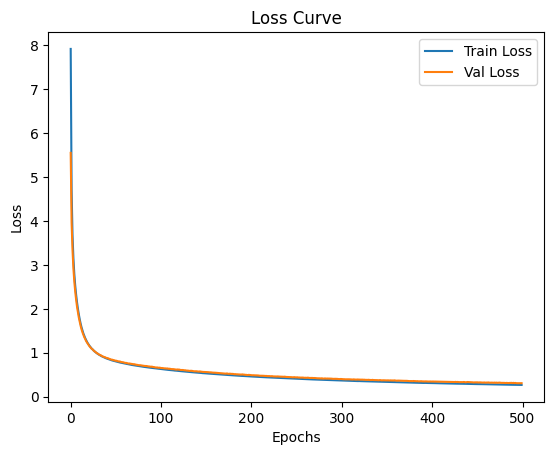

In [30]:
plot_loss(train_losses, val_losses)

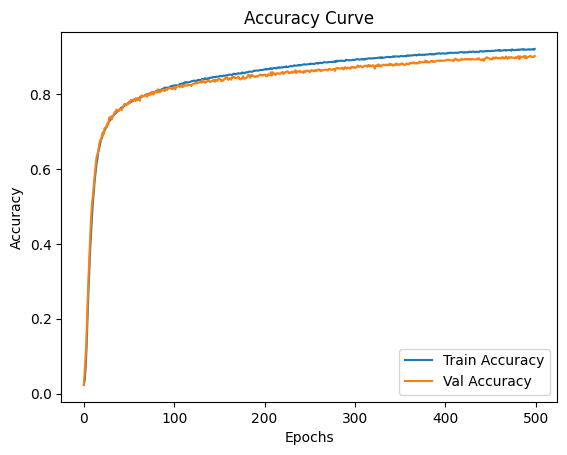

In [31]:
plt.plot(range(len(train_acc)), train_acc, label="Train Accuracy") 
plt.plot(range(len(val_acc)), val_acc, label="Val Accuracy") 

# plt.scatter(range(len(loss_values)), loss_values, c='red', s=20)

plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### AdaDelta

In [32]:
model = MLP(input_dim=num_feats, hidden_dim=3*num_feats, output_dim=num_classes)
model.get_params_count()

2090

In [33]:
adadelta = AdaDelta(epsilon=1e-8, beta=0.90)

In [34]:
train_losses, train_acc, val_losses, val_acc = train_with_acc(model, X_train, y_train, X_val, y_val, optim=adadelta, loss_fn=nll_loss, n_epochs=500, batch_size=512)

Epoch 1/500, Train Loss: 11.824985, Train Accuracy: 3.90 %, Val Loss: 10.877674, Val Accuracy: 3.50 %
Epoch 50/500, Train Loss: 1.855967, Train Accuracy: 47.96 %, Val Loss: 1.837749, Val Accuracy: 49.55 %
Epoch 100/500, Train Loss: 1.289289, Train Accuracy: 66.36 %, Val Loss: 1.292055, Val Accuracy: 66.45 %
Epoch 150/500, Train Loss: 1.067883, Train Accuracy: 71.51 %, Val Loss: 1.079904, Val Accuracy: 71.60 %
Epoch 200/500, Train Loss: 0.949688, Train Accuracy: 74.12 %, Val Loss: 0.966533, Val Accuracy: 74.35 %
Epoch 250/500, Train Loss: 0.874898, Train Accuracy: 75.88 %, Val Loss: 0.894644, Val Accuracy: 75.85 %
Epoch 300/500, Train Loss: 0.822374, Train Accuracy: 77.38 %, Val Loss: 0.843948, Val Accuracy: 77.05 %
Epoch 350/500, Train Loss: 0.782141, Train Accuracy: 78.21 %, Val Loss: 0.805672, Val Accuracy: 77.95 %
Epoch 400/500, Train Loss: 0.749572, Train Accuracy: 79.08 %, Val Loss: 0.774060, Val Accuracy: 79.00 %
Epoch 450/500, Train Loss: 0.721762, Train Accuracy: 79.83 %, Val L

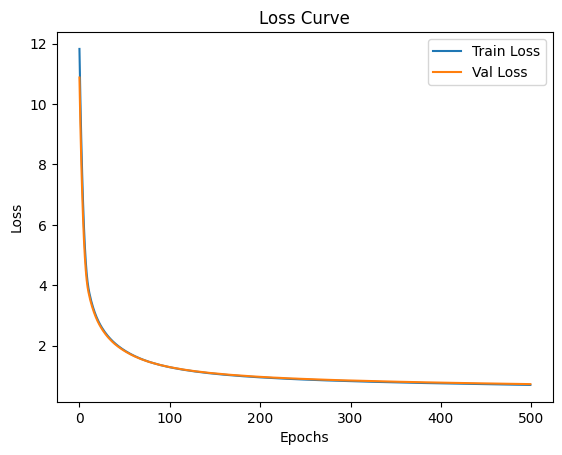

In [35]:
plot_loss(train_losses, val_losses)

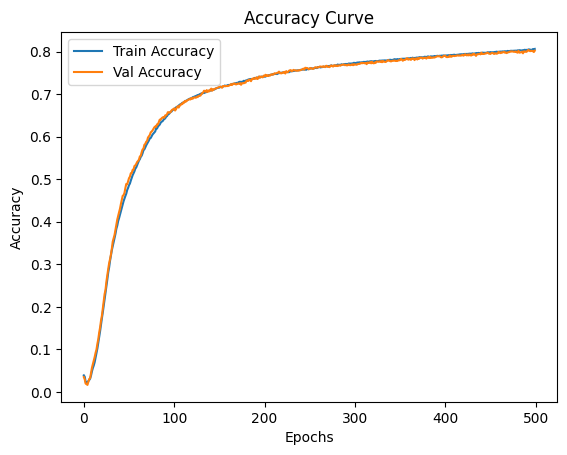

In [36]:
plt.plot(range(len(train_acc)), train_acc, label="Train Accuracy") 
plt.plot(range(len(val_acc)), val_acc, label="Val Accuracy") 

# plt.scatter(range(len(loss_values)), loss_values, c='red', s=20)

plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Adam

In [45]:
model = MLP(input_dim=num_feats, hidden_dim=3*num_feats, output_dim=num_classes)
model.get_params_count()

2090

In [46]:
adam = Adam(lr=0.001, epsilon=1e-8, beta1=0.90, beta2=0.99)

In [47]:
train_losses, train_acc, val_losses, val_acc = train_with_acc(model, X_train, y_train, X_val, y_val, optim=adam, loss_fn=nll_loss, n_epochs=1000, batch_size=512)

Epoch 1/1000, Train Loss: 10.500818, Train Accuracy: 3.21 %, Val Loss: 8.516276, Val Accuracy: 1.90 %
Epoch 50/1000, Train Loss: 1.096908, Train Accuracy: 70.93 %, Val Loss: 1.100710, Val Accuracy: 71.15 %
Epoch 100/1000, Train Loss: 0.797219, Train Accuracy: 77.90 %, Val Loss: 0.816986, Val Accuracy: 78.25 %
Epoch 150/1000, Train Loss: 0.687833, Train Accuracy: 80.77 %, Val Loss: 0.713176, Val Accuracy: 80.55 %
Epoch 200/1000, Train Loss: 0.614305, Train Accuracy: 82.83 %, Val Loss: 0.643546, Val Accuracy: 82.45 %
Epoch 250/1000, Train Loss: 0.556922, Train Accuracy: 84.15 %, Val Loss: 0.589534, Val Accuracy: 83.60 %
Epoch 300/1000, Train Loss: 0.511047, Train Accuracy: 85.36 %, Val Loss: 0.543836, Val Accuracy: 84.20 %
Epoch 350/1000, Train Loss: 0.472965, Train Accuracy: 86.17 %, Val Loss: 0.506938, Val Accuracy: 84.85 %
Epoch 400/1000, Train Loss: 0.440922, Train Accuracy: 87.08 %, Val Loss: 0.474204, Val Accuracy: 85.70 %
Epoch 450/1000, Train Loss: 0.413023, Train Accuracy: 87.98

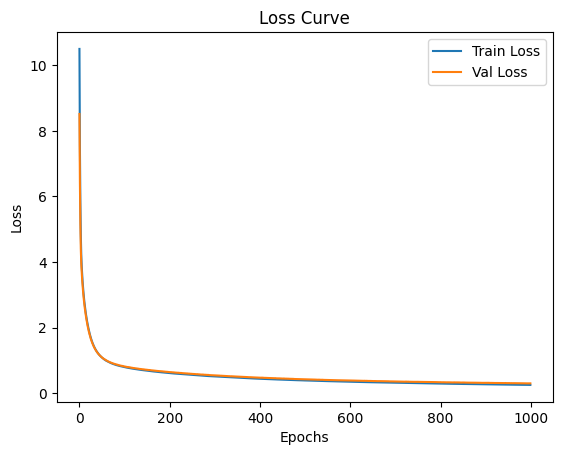

In [48]:
plot_loss(train_losses, val_losses)

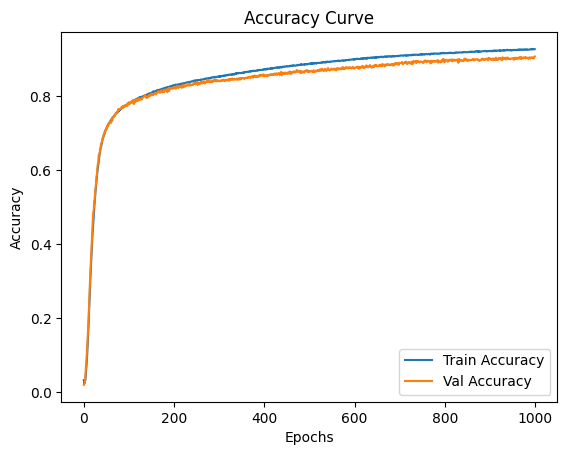

In [49]:
plt.plot(range(len(train_acc)), train_acc, label="Train Accuracy") 
plt.plot(range(len(val_acc)), val_acc, label="Val Accuracy") 

# plt.scatter(range(len(loss_values)), loss_values, c='red', s=20)

plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### AdaMax

In [50]:
model = MLP(input_dim=num_feats, hidden_dim=3*num_feats, output_dim=num_classes)
model.get_params_count()

2090

In [51]:
adamax = AdaMax(lr=0.001, epsilon=1e-8, beta1=0.90, beta2=0.99)

In [52]:
train_losses, train_acc, val_losses, val_acc = train_with_acc(model, X_train, y_train, X_val, y_val, optim=adamax, loss_fn=nll_loss, n_epochs=1000, batch_size=512)

Epoch 1/1000, Train Loss: 10.628006, Train Accuracy: 3.31 %, Val Loss: 8.745090, Val Accuracy: 1.85 %
Epoch 50/1000, Train Loss: 1.427947, Train Accuracy: 61.67 %, Val Loss: 1.418491, Val Accuracy: 62.90 %
Epoch 100/1000, Train Loss: 1.009860, Train Accuracy: 72.65 %, Val Loss: 1.019580, Val Accuracy: 72.50 %
Epoch 150/1000, Train Loss: 0.859784, Train Accuracy: 76.29 %, Val Loss: 0.875908, Val Accuracy: 76.45 %
Epoch 200/1000, Train Loss: 0.777256, Train Accuracy: 78.39 %, Val Loss: 0.798177, Val Accuracy: 78.50 %
Epoch 250/1000, Train Loss: 0.720699, Train Accuracy: 79.79 %, Val Loss: 0.745246, Val Accuracy: 79.40 %
Epoch 300/1000, Train Loss: 0.677482, Train Accuracy: 80.96 %, Val Loss: 0.703202, Val Accuracy: 80.65 %
Epoch 350/1000, Train Loss: 0.641216, Train Accuracy: 81.97 %, Val Loss: 0.669007, Val Accuracy: 81.50 %
Epoch 400/1000, Train Loss: 0.608923, Train Accuracy: 82.84 %, Val Loss: 0.637624, Val Accuracy: 81.95 %
Epoch 450/1000, Train Loss: 0.580208, Train Accuracy: 83.70

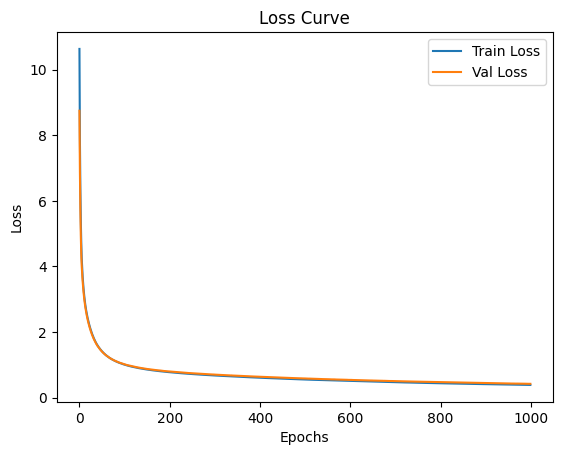

In [53]:
plot_loss(train_losses, val_losses)

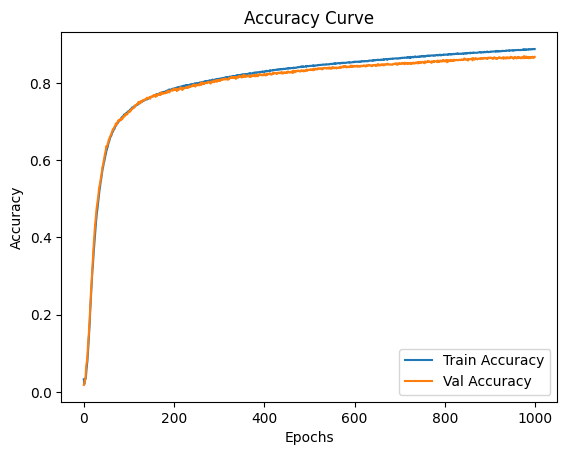

In [54]:
plt.plot(range(len(train_acc)), train_acc, label="Train Accuracy") 
plt.plot(range(len(val_acc)), val_acc, label="Val Accuracy") 

# plt.scatter(range(len(loss_values)), loss_values, c='red', s=20)

plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### NAdam

In [55]:
model = MLP(input_dim=num_feats, hidden_dim=3*num_feats, output_dim=num_classes)
model.get_params_count()

2090

In [56]:
nadam = NAdam(lr=0.001, epsilon=1e-8, beta1=0.90, beta2=0.99)

In [57]:
train_losses, train_acc, val_losses, val_acc = train_with_acc(model, X_train, y_train, X_val, y_val, optim=nadam, loss_fn=nll_loss, n_epochs=1000, batch_size=512)

Epoch 1/1000, Train Loss: 10.225977, Train Accuracy: 3.03 %, Val Loss: 8.290034, Val Accuracy: 1.70 %
Epoch 50/1000, Train Loss: 1.093125, Train Accuracy: 70.99 %, Val Loss: 1.096719, Val Accuracy: 71.20 %
Epoch 100/1000, Train Loss: 0.795190, Train Accuracy: 77.99 %, Val Loss: 0.815096, Val Accuracy: 78.30 %
Epoch 150/1000, Train Loss: 0.685774, Train Accuracy: 80.82 %, Val Loss: 0.711704, Val Accuracy: 80.50 %
Epoch 200/1000, Train Loss: 0.612440, Train Accuracy: 82.80 %, Val Loss: 0.641702, Val Accuracy: 82.50 %
Epoch 250/1000, Train Loss: 0.555038, Train Accuracy: 84.20 %, Val Loss: 0.587603, Val Accuracy: 83.70 %
Epoch 300/1000, Train Loss: 0.509121, Train Accuracy: 85.36 %, Val Loss: 0.542111, Val Accuracy: 84.10 %
Epoch 350/1000, Train Loss: 0.470943, Train Accuracy: 86.24 %, Val Loss: 0.505008, Val Accuracy: 84.90 %
Epoch 400/1000, Train Loss: 0.439025, Train Accuracy: 87.11 %, Val Loss: 0.472369, Val Accuracy: 85.65 %
Epoch 450/1000, Train Loss: 0.411211, Train Accuracy: 88.04

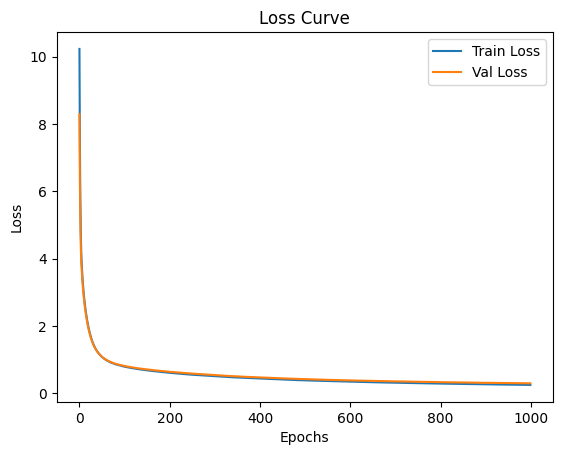

In [58]:
plot_loss(train_losses, val_losses)

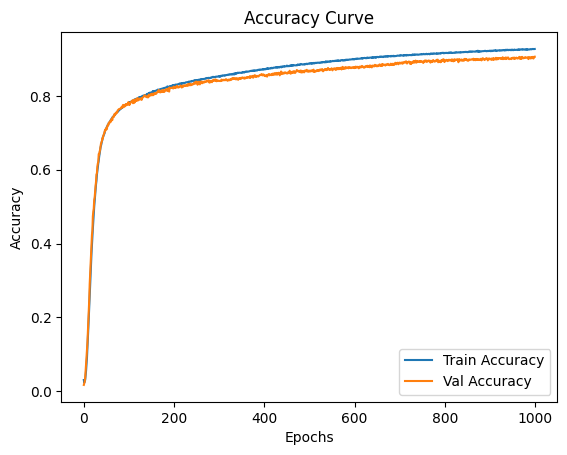

In [59]:
plt.plot(range(len(train_acc)), train_acc, label="Train Accuracy") 
plt.plot(range(len(val_acc)), val_acc, label="Val Accuracy") 

# plt.scatter(range(len(loss_values)), loss_values, c='red', s=20)

plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Best hyperparams

- SGD With momentum with lower lrs and lower epochs
- Adam provides stabler training but more epochs and larger lr
- Lets compare both :)

## Log:
- SGD With Momentum
    - **Train**: Train Loss: 0.136852, Train Accuracy: 95.59 %
    - **Val**: Val Loss: 0.281511, Val Accuracy: 91.20 %
    - **Test**: Test Loss: 0.267866, Test Accuracy: 92.75 %
- Adam
    - **Train**: Train Loss: 0.153504, Train Accuracy: 95.59 %
    - **Val**: Val Loss: 0.213050, Val Accuracy: 92.90 %
    - **Test**: Test Loss: 0.204456, Test Accuracy: 94.00 %

Adam leads to more general models !!

### SGD with momentum

In [75]:
model = MLP(input_dim=num_feats, hidden_dim=3*num_feats, output_dim=num_classes) # for regression
model.get_params_count()

2090

In [76]:
sgd_momentum_optim = SGDWithMomentum(lr=0.0005, gamma=0.90)

In [77]:
train_losses, train_acc, val_losses, val_acc = train_with_acc(model, X_train, y_train, X_val, y_val, optim=sgd_momentum_optim, loss_fn=nll_loss, n_epochs=2000, batch_size=512)

Epoch 1/2000, Train Loss: 4.711770, Train Accuracy: 12.75 %, Val Loss: 2.596821, Val Accuracy: 21.70 %
Epoch 50/2000, Train Loss: 0.492115, Train Accuracy: 85.20 %, Val Loss: 0.571897, Val Accuracy: 82.25 %
Epoch 100/2000, Train Loss: 0.370784, Train Accuracy: 88.61 %, Val Loss: 0.425134, Val Accuracy: 85.65 %
Epoch 150/2000, Train Loss: 0.311592, Train Accuracy: 90.13 %, Val Loss: 0.380693, Val Accuracy: 87.20 %
Epoch 200/2000, Train Loss: 0.292450, Train Accuracy: 90.56 %, Val Loss: 0.345161, Val Accuracy: 88.50 %
Epoch 250/2000, Train Loss: 0.262488, Train Accuracy: 91.72 %, Val Loss: 0.352338, Val Accuracy: 88.55 %
Epoch 300/2000, Train Loss: 0.248733, Train Accuracy: 92.11 %, Val Loss: 0.313002, Val Accuracy: 89.85 %
Epoch 350/2000, Train Loss: 0.236268, Train Accuracy: 92.60 %, Val Loss: 0.351746, Val Accuracy: 88.45 %
Epoch 400/2000, Train Loss: 0.235453, Train Accuracy: 92.51 %, Val Loss: 0.325854, Val Accuracy: 89.70 %
Epoch 450/2000, Train Loss: 0.216962, Train Accuracy: 93.1

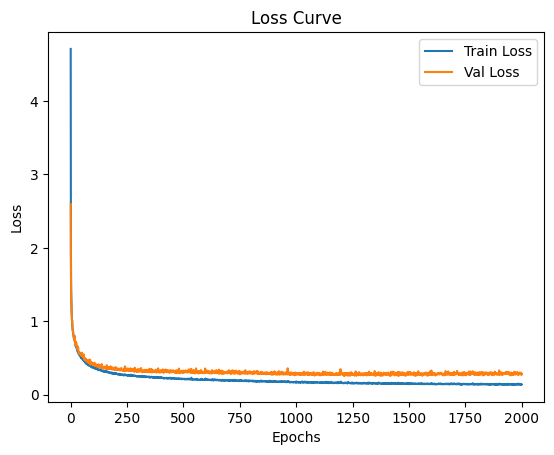

In [78]:
plot_loss(train_losses, val_losses)

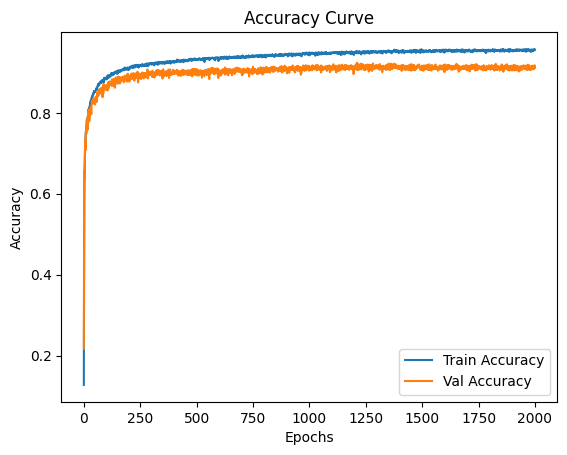

In [79]:
plt.plot(range(len(train_acc)), train_acc, label="Train Accuracy") 
plt.plot(range(len(val_acc)), val_acc, label="Val Accuracy") 

# plt.scatter(range(len(loss_values)), loss_values, c='red', s=20)

plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [80]:
y_test_pred = model.forward(X_test)
test_loss, _ = nll_loss(y_test, y_test_pred)
def get_accuracy(y, y_pred):
    B = y.shape[0]
    pred_classes = y_pred.argmax(axis=1, keepdims=True)
    acc = (pred_classes == y).sum() / B
    return acc
test_accuracy = get_accuracy(y_test, y_test_pred)
print(test_loss)
print(test_accuracy * 100.00)

0.267866634266403
92.75


### Adam

In [81]:
model = MLP(input_dim=num_feats, hidden_dim=3*num_feats, output_dim=num_classes) # for regression
model.get_params_count()

2090

In [82]:
adam = Adam(lr=0.001, epsilon=1e-8, beta1=0.90, beta2=0.99)

In [83]:
train_losses, train_acc, val_losses, val_acc = train_with_acc(model, X_train, y_train, X_val, y_val, optim=adam, loss_fn=nll_loss, n_epochs=2000, batch_size=512)

Epoch 1/2000, Train Loss: 10.500818, Train Accuracy: 3.21 %, Val Loss: 8.516276, Val Accuracy: 1.90 %
Epoch 50/2000, Train Loss: 1.096908, Train Accuracy: 70.93 %, Val Loss: 1.100710, Val Accuracy: 71.15 %
Epoch 100/2000, Train Loss: 0.797219, Train Accuracy: 77.90 %, Val Loss: 0.816986, Val Accuracy: 78.25 %
Epoch 150/2000, Train Loss: 0.687833, Train Accuracy: 80.77 %, Val Loss: 0.713176, Val Accuracy: 80.55 %
Epoch 200/2000, Train Loss: 0.614305, Train Accuracy: 82.83 %, Val Loss: 0.643546, Val Accuracy: 82.45 %
Epoch 250/2000, Train Loss: 0.556922, Train Accuracy: 84.15 %, Val Loss: 0.589534, Val Accuracy: 83.60 %
Epoch 300/2000, Train Loss: 0.511047, Train Accuracy: 85.36 %, Val Loss: 0.543836, Val Accuracy: 84.20 %
Epoch 350/2000, Train Loss: 0.472965, Train Accuracy: 86.17 %, Val Loss: 0.506938, Val Accuracy: 84.85 %
Epoch 400/2000, Train Loss: 0.440922, Train Accuracy: 87.08 %, Val Loss: 0.474204, Val Accuracy: 85.70 %
Epoch 450/2000, Train Loss: 0.413023, Train Accuracy: 87.98

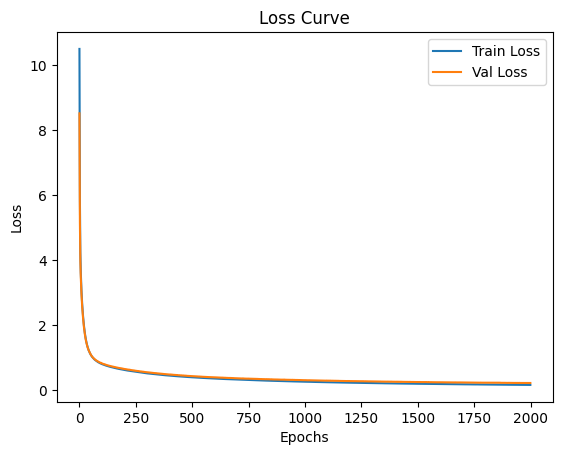

In [84]:
plot_loss(train_losses, val_losses)

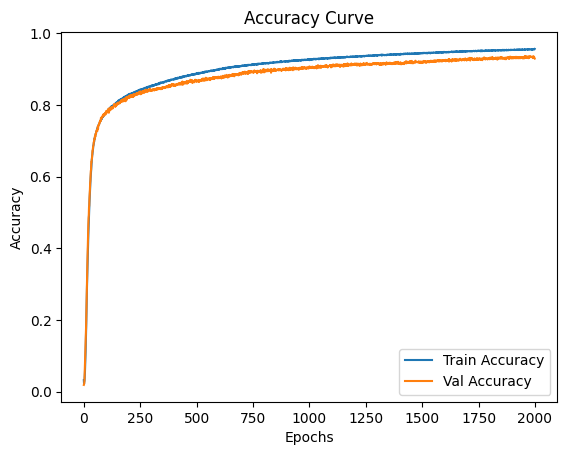

In [85]:
plt.plot(range(len(train_acc)), train_acc, label="Train Accuracy") 
plt.plot(range(len(val_acc)), val_acc, label="Val Accuracy") 

# plt.scatter(range(len(loss_values)), loss_values, c='red', s=20)

plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [86]:
y_test_pred = model.forward(X_test)
test_loss, _ = nll_loss(y_test, y_test_pred)
def get_accuracy(y, y_pred):
    B = y.shape[0]
    pred_classes = y_pred.argmax(axis=1, keepdims=True)
    acc = (pred_classes == y).sum() / B
    return acc
test_accuracy = get_accuracy(y_test, y_test_pred)
print(test_loss)
print(test_accuracy * 100.00)

0.2044564363179436
94.0
